# Preliminary Notes and Vocab

* an image is just a matrix containg a number for each pixel (grayscale) within a coordinate system (or three numbers for each pixel with RGB)
* FashionMNIST - dataset of Zaland`s articles: https://github.com/zalandoresearch/fashion-mnist
* Confusion Matrix - prediction vs reality
* CNN, Convolutional Neural Network, folds images into tensors of numbers
* batch size: how many items used for one training epoch/iteration before calculating loss and optimizing

### Additional ressources
* https://poloclub.github.io/cnn-explainer/ - Convolutional Neural Network Explainer


# Dependencies

In [33]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
from time import time
import random
import math
import os
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd 
from torchinfo import summary

print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"

device = "mps" if torch.backends.mps.is_available() else device

print(f"Using device: {device}")

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Torch version: 2.1.2
Using device: mps


# Functions

## Model Classes

In [24]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units), 
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

class FashionMNISTModelV2(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

class FashionMNISTModelV3(nn.Module): # CONVOLUTIONAL - FALTEND!
    # https://poloclub.github.io/cnn-explainer/
    # https://horace.io/brrr_intro.html

    log_shapes:bool = True

    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # size of the filter, how many pixels * pixels per "scan"
                      stride=1, # pixels per step
                      padding=1), # add extra frame to the input
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # reduces the stuff from like 4 pixels to 1 pixel and takes the max value
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # reduces the stuff from like 4 pixels to 1 pixel
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, # you need to adapt those constants if your input material changes!
                      out_features=output_shape)
        )

    def forward(self, x):
         
        if self.log_shapes : print(f"\nInput shape: {x.shape}")
        x = self.conv_block_1(x)
        if self.log_shapes : print(f"Conv Block 1 returns a shape of: {x.shape}")
        x = self.conv_block_2(x)
        if self.log_shapes : print(f"Conv Block 2 returns a shape of: {x.shape}")
        x = self.classifier(x)
        if self.log_shapes : print(f"Classifier returns a shape of (should fit count of  classes): {x.shape}")

        self.log_shapes = False
        
        return x
        # this is way faster because it does not copy from output to memory and back to the layer
        return self.classifier(self.conv_block_2((self.conv_block_1(x)))) 

### Training and Testing

In [35]:

def train(model: torch.nn.Module,
               data_to_train: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    train_loss, train_accuracy = 0, 0

    model.to(device)

    for batch, (features_to_train, labels_to_train) in enumerate(data_to_train):

        # LOG        
        if batch % int(len(data_to_train) / 5) == 0:
            print(f"\tBatch {batch}", end="")

        # Send to device
        features_to_train, labels_to_train = features_to_train.to(device), labels_to_train.to(device)
    
        # 1. Forward pass
        labels_prediction_logits = model(features_to_train)

        # 2. Calculate loss and accuracy
        batch_loss = loss_fn(labels_prediction_logits, labels_to_train)
        train_loss += batch_loss

        labels_probabilities = torch.softmax(labels_prediction_logits, dim=1)
        labels_predictions = torch.argmax(labels_probabilities, dim=1)

        train_accuracy += accuracy_fn(y_true=labels_to_train, y_pred=labels_predictions) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        batch_loss.backward()
        # fabric.backward(batch_loss)

        # 5. Optimizer step
        optimizer.step()

        # LOG        
        if batch % int(len(data_to_train) / 5) == 0:
            print(f" | Processed images {batch * len(features_to_train)}")

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_to_train)
    train_accuracy /= len(data_to_train)

    return train_loss, train_accuracy

def test(data_to_test: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    

    test_loss, test_accuracy = 0, 0

    model.to(device)
    
    model.eval()
    
    # Turn on inference context manager
    with torch.inference_mode(): 
        for features_to_test, labels_to_test in data_to_test:
            # Send data to GPU
            features_to_test, labels_to_test = features_to_test.to(device), labels_to_test.to(device)
            
            # 1. Forward pass
            labels_prediction_logits = model(features_to_test)
    
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(labels_prediction_logits, labels_to_test)
    
            labels_probabilities = torch.softmax(labels_prediction_logits, dim=1)
            labels_predictions = torch.argmax(labels_probabilities, dim=1)
    
            test_accuracy += accuracy_fn(y_true=labels_to_test, y_pred=labels_predictions)
        
        # Adjust metrics and print out
        test_loss /= len(data_to_test)
        test_accuracy /= len(data_to_test)

    return test_loss, test_accuracy

def train_and_test(
        model_id,
        model,
        epochs,
        metrics):

    start = time()

    if not model_id  in metrics:
        metrics[model_id] = {
            'device': device,
            'batch_size': batch_size,
            'duration': 0,
            'epoch_count': [],
            'loss_values': [], 
            'acc_values': [],
            'test_loss_values': [], 
            'test_acc_values': [] 
        }

    start_epoch = 0 if len(metrics[model_id]['epoch_count']) == 0 else metrics[model_id]['epoch_count'][-1]

    for epoch in range(start_epoch, start_epoch + epochs):

        # LOG
        if epochs < 10 or (epoch % int(epochs / 10) == 0):
            print(f"Epoch {epoch}")

        # TRAIN
        train_loss, train_accuracy = train(model=model,
                                        data_to_train=data_to_train,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        optimizer=optimizer,
                                        device=device)

        # TEST
        test_loss, test_accuracy = test(model=model,
                                        data_to_test=data_to_test,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

        # METRICS  
        metrics[model_id]['epoch_count'].append(epoch)
        metrics[model_id]['loss_values'].append(train_loss)
        metrics[model_id]['acc_values'].append(train_accuracy)
        metrics[model_id]['test_loss_values'].append(test_loss)
        metrics[model_id]['test_acc_values'].append(test_accuracy)

        # LOG
        if epochs < 10 or (epoch % int(epochs / 10) == 0):
            print(f"\tLoss {train_loss:.2f} | Test Loss {test_loss:.2f} | Acc {test_accuracy:.2f} | Test Acc {test_accuracy:.2f}")

    metrics[model_id]['duration'] += time() - start

    return metrics, model

### Helper Functions

In [36]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def plot_loss_and_accuracy(
    axis,
    fig,
    epoch_count,
    loss_values,
    test_loss_values,
    acc_values, 
    test_acc_values
  ):


    loss_values = np.array(torch.tensor(loss_values).cpu().numpy())
    test_loss_values = np.array(torch.tensor(test_loss_values).cpu().numpy())

    # plt.figure(figsize = (10, 7))

    axis.plot(epoch_count, loss_values, label = "train loss", color="tab:red")
    axis.plot(epoch_count, test_loss_values, label = "test loss", color="tab:red", linestyle="dashed")
    # axis.axis(ymin=0,ymax=1)
    axis.set_ylabel('loss')
    axis.legend(loc="upper left")

    axis2 = axis.twinx()

    axis2.plot(epoch_count, acc_values, label = "train accuracy", color="tab:blue")
    axis2.plot(epoch_count, test_acc_values, label = "test accuracy", color="tab:blue", linestyle="dashed")
    axis2.axis(ymin=0,ymax=100)
    axis2.set_ylabel('accuracy')
    axis2.legend(loc="upper right")

    # axis.title('training and test loss curves')
    fig.suptitle('loss and accuracy')

    axis.set_xlabel('epochs')

def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
    
    prediction_probabilities = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            prediction_logit = model(sample)

            prediction_probablity = torch.softmax(prediction_logit.squeeze(), dim=0).cpu()

            prediction_probablity = prediction_probablity.argmax()

            prediction_probabilities.append(prediction_probablity)


    return torch.stack(prediction_probabilities)

# Data

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


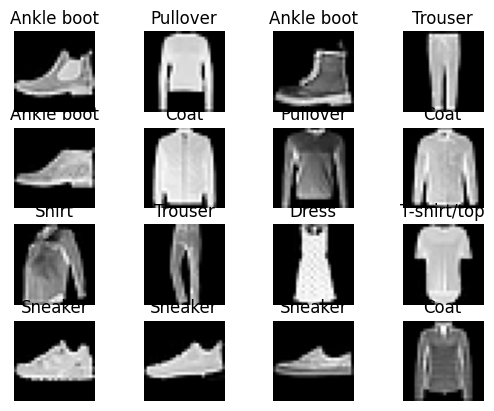

In [37]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                   )
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None
                                  )


class_names = train_data.classes

print(class_names)

fig = plt.Figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label_idx = train_data[random_idx]
    labels = {idx: label for label, idx in train_data.class_to_idx.items()}
    plt.subplot(rows, cols,  i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(labels[label_idx])
    plt.axis(False)

# Training and Testing

In [38]:
# reset if required
metrics = {}

## Parameters

In [39]:
epochs = 2

learning_rate = 0.1

batch_size = 32

model_suffix = 'test'

num_workers = os.cpu_count()

## Run

In [40]:
# fabric = Fabric(accelerator=device)
# fabric.launch()

# LOAD DATA
data_to_train = DataLoader(dataset=train_data,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=True)

data_to_test = DataLoader(dataset=test_data,
                                batch_size=batch_size,
                                num_workers=num_workers,
                                shuffle=False) # order does not matter, this data will not be used for learning


print(f"Found {len(data_to_train)} training batches a {batch_size} images")

# INIT MODEL
model_0 = FashionMNISTModelV0(input_shape=784, # height * width or 1 if black/white images provided
                            hidden_units=10,
                            output_shape=len(class_names))


# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()

# OPTIMIZER
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=learning_rate)

# model_0, optimizer = fabric.setup(model_0, optimizer)
# data_to_train = fabric.setup_dataloaders(data_to_train)

model_id = f"{model_0.__class__.__name__}|{device}|{batch_size}|{model_suffix}"

metrics, model_0 = train_and_test(model_id=model_id,
                         model=model_0,
                         epochs=epochs,
                         metrics=metrics)


Found 1875 training batches a 32 images
Epoch 0
	Batch 0 | Processed images 0
	Batch 375 | Processed images 12000
	Batch 750 | Processed images 24000
	Batch 1125 | Processed images 36000
	Batch 1500 | Processed images 48000
	Loss 0.59 | Test Loss 0.50 | Acc 82.04 | Test Acc 82.04
Epoch 1
	Batch 0 | Processed images 0
	Batch 375 | Processed images 12000
	Batch 750 | Processed images 24000
	Batch 1125 | Processed images 36000
	Batch 1500 | Processed images 48000
	Loss 0.48 | Test Loss 0.49 | Acc 82.79 | Test Acc 82.79


## Visualize

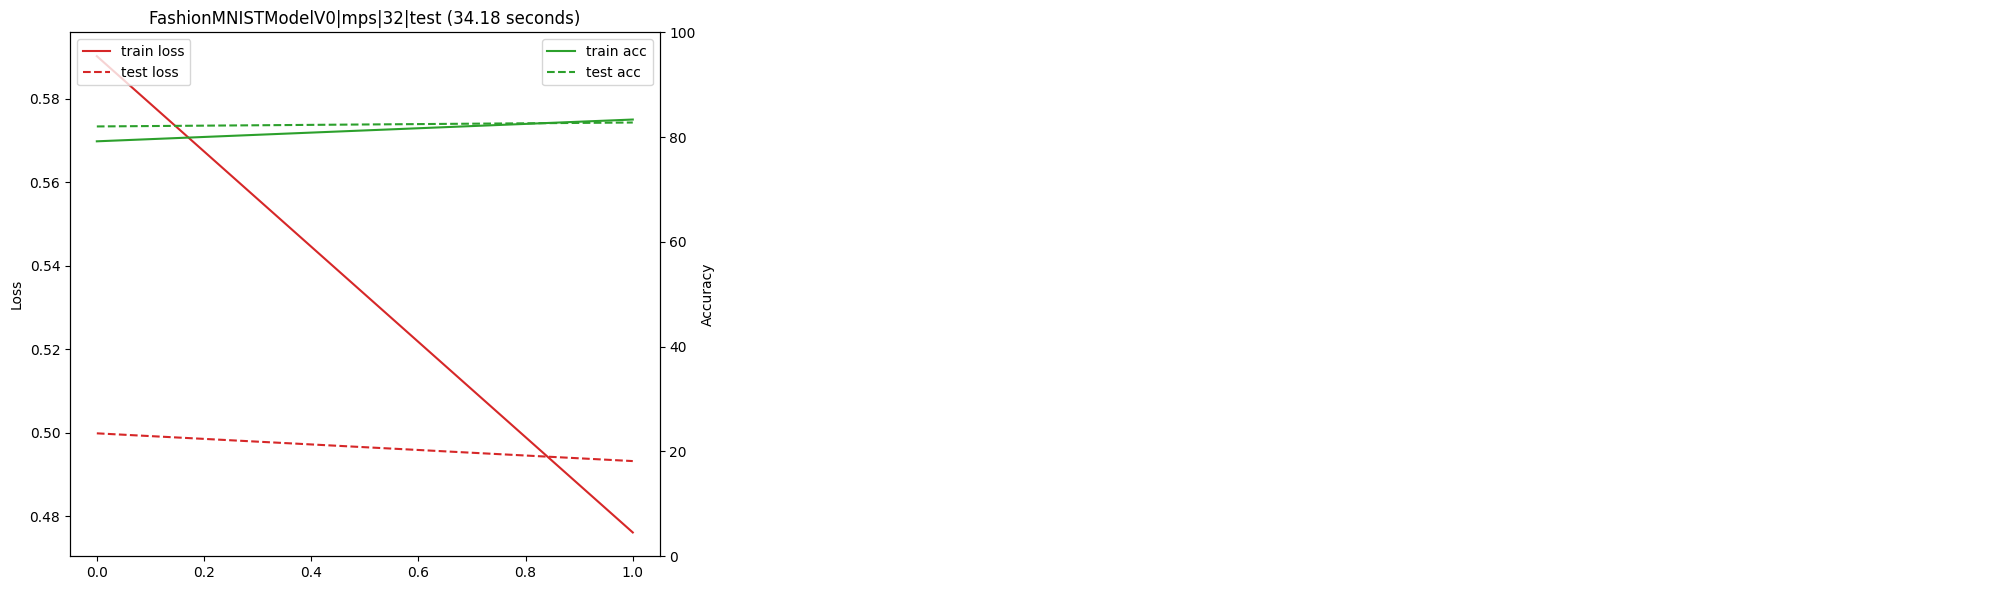

In [41]:
num_metrics = len(metrics)
rows, cols = math.ceil(num_metrics / 3), 3

fig, axs = plt.subplots(rows, cols, figsize=(20, 6 * rows))

for i, (model_name, data) in enumerate(metrics.items()):

    duration = data['duration']
    epoch_count = data['epoch_count']
    loss_values = np.array(torch.tensor(data['loss_values']).cpu().numpy())
    test_loss_values = np.array(torch.tensor(data['test_loss_values']).cpu().numpy())
    acc_values = data['acc_values']
    test_acc_values = data['test_acc_values']

    row = i // cols
    col = i % cols

    ax = axs.flat[i]
    ax.plot(epoch_count, loss_values, label="train loss", color="tab:red")
    ax.plot(epoch_count, test_loss_values, label="test loss", color="tab:red", linestyle="dashed")
    #ax.set_ylim(0, 1)
    ax.set_ylabel('Loss')
    ax.legend(loc="upper left")

    ax_acc = ax.twinx()
    ax_acc.plot(epoch_count, acc_values, label="train acc", color="tab:green")
    ax_acc.plot(epoch_count, test_acc_values, label="test acc", color="tab:green", linestyle="dashed")
    ax_acc.set_ylim(0, 100)
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend(loc="upper right")

    ax.set_title(f'{model_name} ({duration:.2f} seconds)')

# Hide empty subplots if any
for i in range(num_metrics, rows * cols):
    axs.flat[i].axis('off')

plt.tight_layout()
plt.show()

# Apply

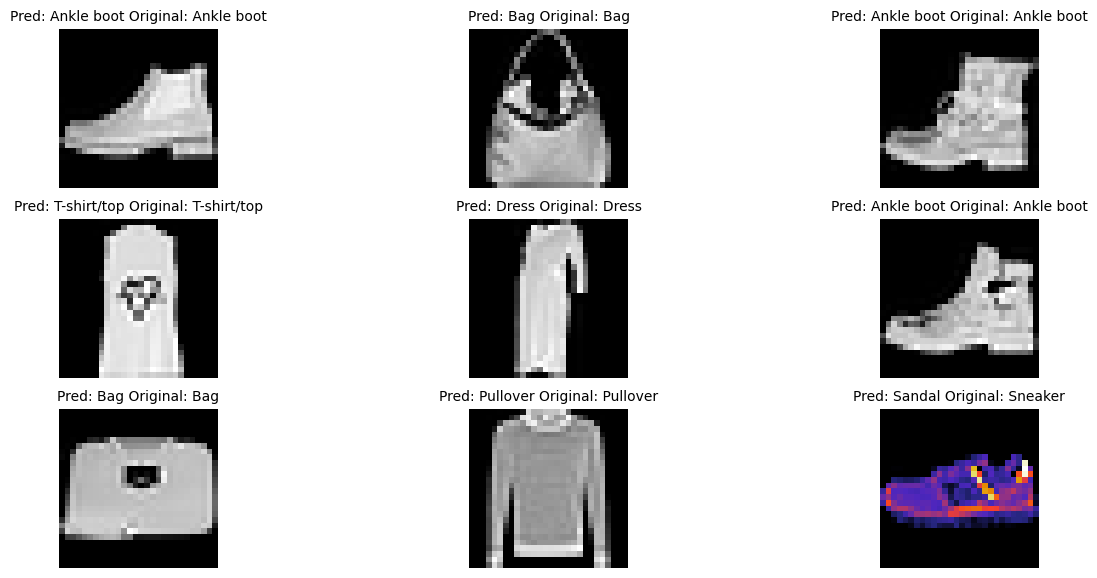

In [42]:
sample_size = 9
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=sample_size):
    test_samples.append(sample)
    test_labels .append(label)

predicited_labels = make_predictions(model=model_0,
                                          data=test_samples,
                                          device=device)

rows, cols = 3, 3
plt.figure(figsize=(15, 7))  #
for i in range(1, rows * cols + 1):
    plt.subplot(rows, cols,  i)
    predicted_label = class_names[predicited_labels[i - 1]]
    original_label = class_names[test_labels[i - 1]]
    cmap = "CMRmap" if predicted_label != original_label else "gray"
    plt.title(f"Pred: {predicted_label} Original: {original_label}", fontsize=10)
    plt.imshow(test_samples[i - 1].squeeze(), cmap=cmap)
    plt.axis(False)
    

#

## Confusing Matrix

In [43]:
test_images = [image.unsqueeze(dim=0).to(torch.float) for image in DataLoader(dataset=test_data).dataset.data]
original_labels = DataLoader(dataset=test_data).dataset.targets


predicted_labels = make_predictions(model=model_0,
                                          data=test_images,
                                          device=device)

pd.DataFrame({"Prediction": predicted_labels[:10].numpy(), "Original": original_labels[:10].numpy()})

,Prediction,Original
0,9,9
1,2,2
2,1,1
3,1,1
4,2,6
5,1,1
6,4,4
7,4,6
8,7,5
9,7,7


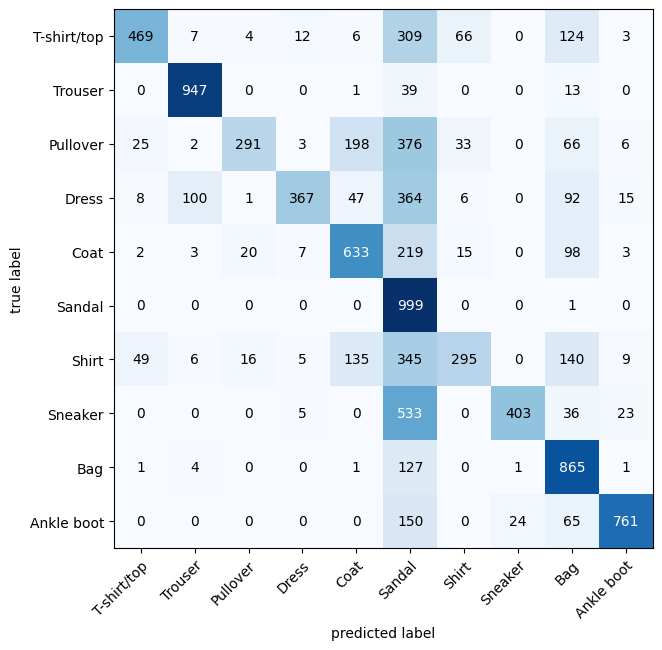

In [588]:
confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confusion_matrix_tensor = confusion_matrix(preds=predicted_labels,
                                           target=original_labels)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10, 7)
                                )

## Model Info

In [32]:
input_size=[1, 1, 28, 28] # batch 1, color channels, width, height - refer to the output of the forward function of the model
summary(model_0, input_size=input_size, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNISTModelV3                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─ReLU: 2-2                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 10, 28, 28]           910
│    └─ReLU: 2-4                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-6                       [1, 10, 14, 14]           910
│    └─ReLU: 2-7                         [1, 10, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 10, 14, 14]           910
│    └─ReLU: 2-9                         [1, 10, 14, 14]           --
│    └─MaxPool2d: 2-10                   [1, 10, 7, 7]             --
├─Sequentia

# Tuning

In [3]:
from lightning.fabric import Fabric